# Periodicity Feature Extraction and Similarity Metrics

**Periodicity feature extraction**: Beat spectra, periodicity spectra.

**Similarity Metrics**: Cosine similarity, DPW distance.

All functions have been wrapped up in `./src/periodicity.py` and `./src/dpw.py`.

In [1]:
import librosa
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from numpy.linalg import norm

## Beat Spectra

Calculating beat spectra using method described in *[The beat spectrum: a new approach to rhythm analysis](https://ieeexplore.ieee.org/document/1237863/)* (J. Foote et al, 2001)

In [2]:
# Using same params as the paper
t_frame = 10
sr = 22000
frame_len = 256
hop_len = 128

# Should be insensitive to quality
bach_fname = "./data/audio/Prelude and Fugue No. 1 in C Major, BWV 846：Prelude.mp3" 

# Load audio
# Set offset=0.7 to remove the silent period (trivial, just to be consistent with the paper)
y_frame, sr = librosa.load(bach_fname, sr=sr, offset=0.7, mono=True, duration=t_frame)

# FFT
S = np.abs(librosa.stft(y_frame, n_fft=frame_len, win_length=frame_len, hop_length=hop_len))

# Log Magnitude
S_db = librosa.power_to_db(S**2, ref=1.0)

# Cosine Similarity Matrix
norm_S_db = S_db/norm(S_db, axis=0)
s = np.dot(norm_S_db.T, norm_S_db)

/usr/local/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


#### display the similarity matrix

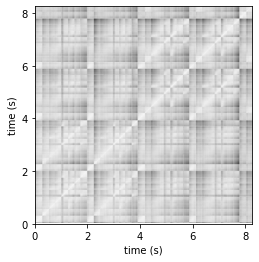

In [3]:
# 1/sr*frame_len + np.arange(len(s))/sr*hop_len
t_tick = np.arange(0, t_frame, 2).astype(int)
tick_idx = np.round((t_tick - 1/sr*frame_len) * sr/hop_len)
t_tick_label = [str(i) for i in t_tick]

# Just for visualization
fig, ax = plt.subplots()

len_display = int(8.25*sr/hop_len)
s_display = s[:len_display, :len_display]
ax.imshow(s_display[::-1,:], cmap='gray') # make (0,0) starts from bottom left
ax.set_xticks(ticks=tick_idx, labels=t_tick_label)
ax.set_yticks(ticks=len_display - np.array(tick_idx[::-1]), labels=t_tick_label[::-1])
ax.set_xlabel("time (s)")
ax.set_ylabel("time (s)")
plt.show()

### Deriving beat spectrum 

#### Baseline
Summing along the diagonal

$B(l) = \sum_{k \in R}S(k,k+l)$ where $R$ is continous range.

In [4]:
def rescale(bs):
    # rescale to 0-1
    v_min, v_max = np.min(bs), np.max(bs)
    return (bs - v_min)/(v_max - v_min)

t_lag = 5
n = int(t_lag/(1/sr*hop_len))

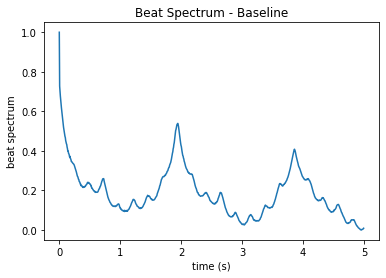

In [5]:
bs_baseline = np.array([np.trace(s[i:i+n, :n]) for i in range(n)])

plt.plot(np.arange(n)/sr*hop_len, rescale(bs_baseline)) 
plt.xlabel("time (s)")
plt.ylabel("beat spectrum")
plt.title("Beat Spectrum - Baseline")
plt.show()

#### auto-correlation
$B(k,l) = \sum_{i,j}S(i,j)S(i+k,j+l)$

Because $B(k,l)$ is symmetric, it is only necessary to sum over one variable, giving the one-dimensional result $B(l)$.

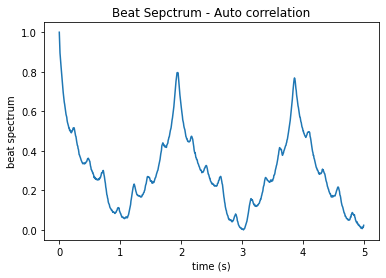

In [6]:
i = 0
bs = [np.sum(s[i:i+n, i:i+n]/norm(s[i:i+n, i:i+n]) * s[i:i+n, j:j+n]/norm(s[i:i+n, j:j+n])) for j in range(n)]

plt.plot(np.arange(n)/sr*hop_len, rescale(bs))
plt.xlabel("time (s)")
plt.ylabel("beat spectrum")
plt.title("Beat Sepctrum - Auto correlation")
plt.show()

/usr/local/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


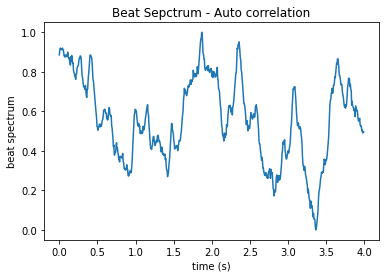

In [7]:
# Another example, using same params as the paper

fname = "./data/audio/Dave Brubeck - Take Five.mp3"
y_jazz, sr = librosa.load(fname, sr=sr, offset=1.58, mono=True, duration=t_frame)

S_jazz = np.abs(librosa.stft(y_jazz, n_fft=frame_len, win_length=frame_len, hop_length=hop_len))
S_db_jazz = librosa.power_to_db(S_jazz**2, ref=1.0)

# Cosine Similarity Matrix
norm_S_db_jazz = S_db_jazz/norm(S_db_jazz, axis=0)
s_jazz = np.dot(norm_S_db_jazz.T, norm_S_db_jazz)


t_lag = 4
n = int(t_lag/(1/sr*hop_len))

i = 0
bs_jazz = [np.sum(s_jazz[i:i+n, i:i+n]/norm(s_jazz[i:i+n, i:i+n]) * s[i:i+n, j:j+n]/norm(s[i:i+n, j:j+n])) for j in range(n)]

plt.plot(np.arange(n)/sr*hop_len, rescale(bs_jazz))
plt.xlabel("time (s)")
plt.ylabel("beat spectrum")
plt.title("Beat Sepctrum - Auto correlation")
plt.show()

Note: `scipy.signal.correlated2d` is very inefficient, takes hours to calculate one $B(k,l)$. My solution is no where near the figure from the paper, not sure how did they reduce the dimension of $B(k,l)$ to $B(l)$.

## Periodicity Spectra

Calculate periodicity spectra using method described in: *Rhythmic similarity of music based on dynamic periodicity warping* (https://ieeexplore.ieee.org/document/4518085) by A. Holzapfel et al.

In [8]:
from scipy.fft import fft

min_bpm = 10
max_bpm = 1000

D = np.abs(librosa.feature.melspectrogram(y=y_frame, sr=sr))
onset_env = librosa.onset.onset_strength(S=librosa.core.power_to_db(D), sr=sr)

spectrum = np.abs(fft(onset_env))

frame_len = len(onset_env)
spectrum = spectrum[1:frame_len // 2]
spectrum = spectrum/np.sum(spectrum)

max_idx = int(max_bpm / 60 * t_frame)
min_idx = int(min_bpm / 60 * t_frame)

spectrum = spectrum[min_idx: max_idx]

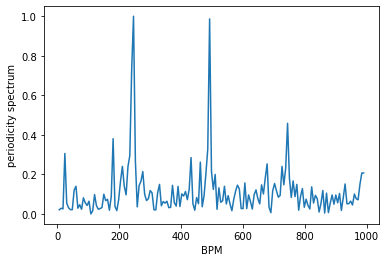

In [9]:
xf = np.arange(1, max_idx - min_idx+1)/t_frame
plt.plot(xf*60, rescale(spectrum))
plt.xlabel("BPM")
plt.ylabel("periodicity spectrum")
plt.show()

## Spectrogram

The periodicity spectrogram calculated on the entire song.

In [10]:
y, sr = librosa.load(bach_fname, sr=22050, mono=True)

/usr/local/lib/python3.9/site-packages/librosa/util/decorators.py:88: UserWarning: PySoundFile failed. Trying audioread instead.
  return f(*args, **kwargs)


### Beat Spectrogram

In [11]:
from src.periodicity import beat_spectrum

t = len(y)/sr # duration
t_frame = 10 # window size in second
t_hop = 5 # hop_size in second

spectrogram = []
for i in np.arange(0, int((t - t_frame)/t_hop)):
    t_st = i*t_hop
    t_ed = i*t_hop + t_frame

    y_win = y[int(t_st * sr): int(t_ed * sr)]
    bs = beat_spectrum(y_win, frame_len=frame_len, hop_len=hop_len)
    spectrogram.append(bs)

spectrogram = np.array(spectrogram)

# Normalize and transpose to (periodicty/t_lag, time)
spectrogram = spectrogram.T/np.max(spectrogram)

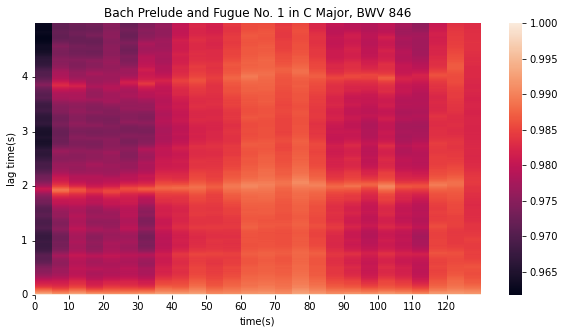

In [12]:
fig, ax = plt.subplots(figsize=(10, 5))

ax = sns.heatmap(spectrogram[::-1,:]) # set bottom left as (0,0)

n_lag, n_t = spectrogram.shape
x_ticks = np.arange(0, n_t, 2)
ax.set_xticks(x_ticks, labels=x_ticks*t_hop)

y_ticks = n_lag-(np.arange(t_hop)/(1/sr)/hop_len).astype(int)
y_labels = np.arange(t_hop).astype(int)

ax.set_yticks(y_ticks, labels=y_labels)

ax.set_xlabel("time(s)")
ax.set_ylabel("lag time(s)")
ax.set_title("Bach Prelude and Fugue No. 1 in C Major, BWV 846")

plt.show()

### Periodicity Spectrogram

In [13]:
from scipy.fft import fft

max_bpm = 1000
min_bpm = 10

D = np.abs(librosa.feature.melspectrogram(y=y, sr=sr))
onset_env = librosa.onset.onset_strength(S=librosa.core.power_to_db(D), sr=sr)

# For calculating frequency resolution
times = librosa.times_like(D, sr=sr)
onset_env_sr = np.mean(1 / np.diff(times))

spectrogram = []

frame_len = int(t_frame * onset_env_sr)

t = len(y) / sr
for t_st in np.arange(0, t - t_frame, t_hop):
    idx_st = int(t_st * onset_env_sr)
    spectrogram.append(fft(onset_env[idx_st:idx_st + frame_len]))

spectrogram = np.array(np.abs(spectrogram)).T

spectrogram = spectrogram[1:frame_len // 2, :]
spectrogram = spectrogram / np.sum(spectrogram, axis=0)  # normalize

max_idx = int(max_bpm / 60 * t_frame)
min_idx = int(min_bpm / 60 * t_frame)

spectrogram = spectrogram[min_idx: max_idx]

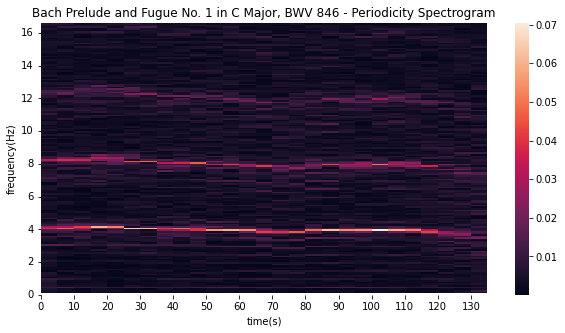

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.heatmap(spectrogram[::-1, :]) # set bottom left as (0,0)

n_freq, n_frame = spectrogram.shape

x_ticks = np.arange(0, n_frame, 2)
ax.set_xticks(x_ticks, labels=x_ticks*t_hop)

y_labels = np.arange(0, 17, 2)
y_ticks = n_freq - (y_labels - min_bpm/60)*t_frame
ax.set_yticks(y_ticks.astype(int), labels=y_labels)

ax.set_xlabel("time(s)")
ax.set_ylabel("frequency(Hz)")
ax.set_title("Bach Prelude and Fugue No. 1 in C Major, BWV 846 - Periodicity Spectrogram")

plt.show()